In [ ]:
pip install tf-nightly

     |████████████████████████████████| 345.4MB 44kB/s 
     |████████████████████████████████| 460kB 39.1MB/s 
     |████████████████████████████████| 8.9MB 39.1MB/s 


In [ ]:
pip install tensorflow==2.0.0

     |████████████████████████████████| 86.3MB 35kB/s 
     |████████████████████████████████| 3.8MB 38.5MB/s 
     |████████████████████████████████| 450kB 25.0MB/s 
     |████████████████████████████████| 51kB 5.7MB/s 
  Created wheel for gast: filename=gast-0.2.2-cp36-none-any.whl size=7540 sha256=cef04a7c6ac241943e0bddd5d0a4fb3210b716ac74cb6b33c49659dfed2ac8e8
  Stored in directory: /root/.cache/pip/wheels/5c/2e/7e/a1d4d4fcebe6c381f378ce7743a3ced3699feb89bcfbdadadd
Successfully built gast
ERROR: tf-nightly 2.4.0.dev20200824 has requirement gast==0.3.3, but you'll have gast 0.2.2 which is incompatible.
ERROR: tensorflow-probability 0.11.0 has requirement gast>=0.3.2, but you'll have gast 0.2.2 which is incompatible.
  Found existing installation: tensorboard 2.3.0
    Uninstalling tensorboard-2.3.0:
      Successfully uninstalled tensorboard-2.3.0
  Found existing installation: tensorflow-estimator 2.3.0
    Uninstalling tensorflow-estimator-2.3.0:
      Successfully uninstalled ten

In [ ]:
from __future__ import absolute_import, division, print_function, unicode_literals
import os
import numpy as np
import matplotlib.pyplot as plt

import tensorflow as tf
keras = tf.keras

AUTOTUNE = tf.data.experimental.AUTOTUNE

import IPython.display as display
from PIL import Image

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Go to this URL in a browser: https://accounts.google.com/o/oauth2/auth?client_id=947318989803-6bn6qk8qdgf4n4g3pfee6491hc0brc4i.apps.googleusercontent.com&redirect_uri=urn%3aietf%3awg%3aoauth%3a2.0%3aoob&scope=email%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdocs.test%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive.photos.readonly%20https%3a%2f%2fwww.googleapis.com%2fauth%2fpeopleapi.readonly&response_type=code

Enter your authorization code:
··········
Mounted at /content/drive


In [ ]:
!unzip -uq "/content/drive/My Drive/riskmap_urop/none"
!unzip -uq "/content/drive/My Drive/riskmap_urop/severe" 

In [ ]:
list_ds = tf.data.Dataset.list_files(str("all_*/*"))

In [ ]:
def get_label(file_path):
  parts = tf.strings.split(file_path, os.path.sep)
  return parts[-2] == class_names

def decode_img(img):
  img = tf.image.decode_jpeg(img, channels=3)
  img = tf.cast(img, tf.float32)
  img = (img/127.5) - 1
  return tf.image.resize(img, [256, 256])

def process_path(file_path):
  label = get_label(file_path)
  img = tf.io.read_file(file_path)
  img = decode_img(img)
  print(list(label))
  return img, label

In [ ]:
class_names = ['all_none', 'all_severe']

In [ ]:
labeled_ds = list_ds.map(process_path, num_parallel_calls=AUTOTUNE)
labeled_ds

OperatorNotAllowedInGraphError: ignored

In [ ]:
train_size = int(0.8 * 23272)
test_size = int(0.2 * 23272)

#train_size = 2400
#test_size = 600

train_dataset = labeled_ds.take(train_size)
test_dataset = labeled_ds.skip(train_size)
test_dataset = test_dataset.take(test_size)

print(train_dataset)
print(test_dataset)

<TakeDataset shapes: ((256, 256, 3), (2,)), types: (tf.float32, tf.bool)>
<TakeDataset shapes: ((256, 256, 3), (2,)), types: (tf.float32, tf.bool)>


In [ ]:
train_dataset = train_dataset.shuffle(5000).batch(32)
test_dataset = test_dataset.shuffle(5000).batch(32)

print(train_dataset)
print(test_dataset)

<BatchDataset shapes: ((None, 256, 256, 3), (None, 2)), types: (tf.float32, tf.bool)>
<BatchDataset shapes: ((None, 256, 256, 3), (None, 2)), types: (tf.float32, tf.bool)>


In [ ]:
IMG_SHAPE = (256, 256, 3)

base_model = tf.keras.applications.VGG16(input_shape=IMG_SHAPE,
                                               include_top=False,
                                               weights='imagenet')

base_model.trainable = False

58892288/58889256 [==============================] - 1s 0us/step


In [ ]:
global_average_layer = tf.keras.layers.GlobalAveragePooling2D()
# first parameter of Dense is how many categories
# the algorithm is predicting for
prediction_layer = keras.layers.Dense(2, activation="softmax")

model = tf.keras.Sequential([
  base_model
])

model.add(tf.keras.layers.Conv2D(32, (3, 3), activation='relu'))
model.add(tf.keras.layers.MaxPooling2D((2, 2), padding = 'same'))
model.add(tf.keras.layers.Conv2D(64, (3, 3), activation='relu'))
model.add(tf.keras.layers.MaxPooling2D((2, 2), padding = 'same'))

model.add(tf.keras.layers.Dropout(0.3))
model.add(global_average_layer)
model.add(tf.keras.layers.Dense(512, activation = 'sigmoid'))
model.add(prediction_layer)

In [ ]:
base_learning_rate = 0.001
model.compile(optimizer=tf.keras.optimizers.Adam(lr=base_learning_rate),
              loss='categorical_crossentropy',
              metrics=['accuracy'])

In [ ]:
history = model.fit(train_dataset,
                    epochs = 10,
                    steps_per_epoch = 10,
                    validation_data = test_dataset, 
                    validation_steps = 10)

Epoch 1/10
10/10 [==============================] - 172s 17s/step - loss: 0.7067 - accuracy: 0.5000 - val_loss: 0.6405 - val_accuracy: 0.6562
Epoch 2/10
10/10 [==============================] - 167s 17s/step - loss: 0.5781 - accuracy: 0.7188 - val_loss: 0.4747 - val_accuracy: 0.7719
Epoch 3/10
10/10 [==============================] - 168s 17s/step - loss: 0.3907 - accuracy: 0.8438 - val_loss: 0.4530 - val_accuracy: 0.8094
Epoch 4/10
10/10 [==============================] - 166s 17s/step - loss: 0.4953 - accuracy: 0.8000 - val_loss: 0.3408 - val_accuracy: 0.8625
Epoch 5/10
10/10 [==============================] - 168s 17s/step - loss: 0.3833 - accuracy: 0.8500 - val_loss: 0.3643 - val_accuracy: 0.8406
Epoch 6/10
10/10 [==============================] - 167s 17s/step - loss: 0.3418 - accuracy: 0.8594 - val_loss: 0.2908 - val_accuracy: 0.8875
Epoch 7/10
10/10 [==============================] - 170s 17s/step - loss: 0.3445 - accuracy: 0.8656 - val_loss: 0.3253 - val_accuracy: 0.8594
Epoch 

In [ ]:
model.save("/content/drive/My Drive/riskmap_urop_data/NN_binary_4.hdf5")
# !cp NN_binary.hdf5 drive/My\ Drive/riskmap_urop_data

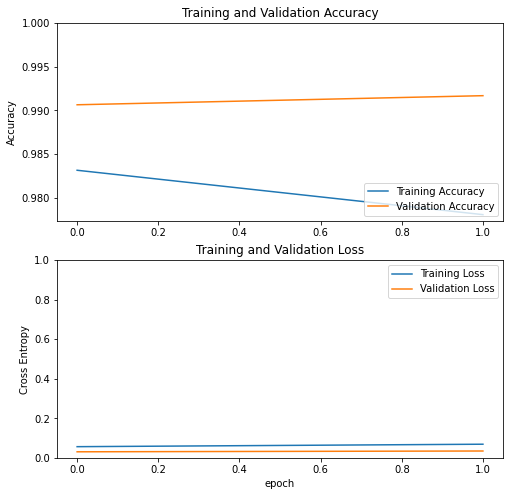

In [ ]:
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']

loss = history.history['loss']
val_loss = history.history['val_loss']

plt.figure(figsize=(8, 8))
plt.subplot(2, 1, 1)
plt.plot(acc, label='Training Accuracy')
plt.plot(val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.ylabel('Accuracy')
plt.ylim([min(plt.ylim()),1])
plt.title('Training and Validation Accuracy')

plt.subplot(2, 1, 2)
plt.plot(loss, label='Training Loss')
plt.plot(val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.ylabel('Cross Entropy')
plt.ylim([0,1.0])
plt.title('Training and Validation Loss')
plt.xlabel('epoch')
plt.show()

In [ ]:
from keras.preprocessing.image import img_to_array, load_img
import matplotlib.pyplot as plt
import matplotlib.image as mpimg

def img_show(img):

  img = load_img(img)
  imgplot = plt.imshow(img)
  plt.show()

def img_prediction(img):

  img = load_img(img)
  img = img_to_array(img)
  img = np.expand_dims(img, axis=0)

  img = tf.cast(img, tf.float32)
  img = (img/127.5) - 1
  img = tf.image.resize(img, [256, 256])

  pred = model.predict(img)
 

  damage_dict = {}
  damage_dict['No damage'] = pred[0][0]
  damage_dict['Mild damage'] = pred[0][1]
  damage_dict['Severe damage'] = pred[0][2]

  print("No damage:", damage_dict['No damage'])
  print("Some damage:", damage_dict['Severe damage'])
  print("Classification: ", max(damage_dict, key = damage_dict.get))

In [ ]:
!unzip -uq "/content/drive/My Drive/riskmap_urop/puerto_rico_test" 

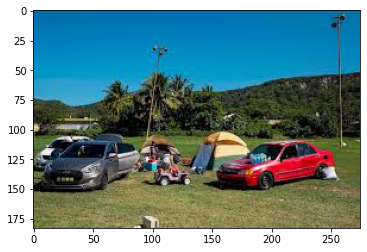

No damage: 0.9999291
Some damage: 6.946501e-05
Classification:  No damage


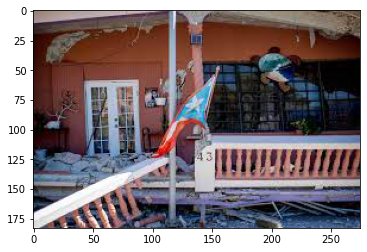

No damage: 0.9621415
Some damage: 0.037847456
Classification:  No damage


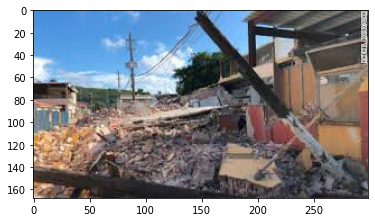

No damage: 0.027684098
Some damage: 0.97230387
Classification:  Severe damage


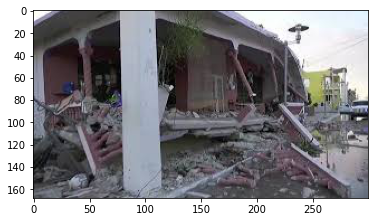

No damage: 0.011464329
Some damage: 0.98852986
Classification:  Severe damage


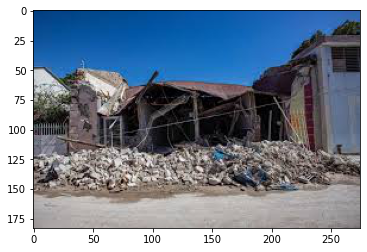

No damage: 0.016133836
Some damage: 0.9838574
Classification:  Severe damage


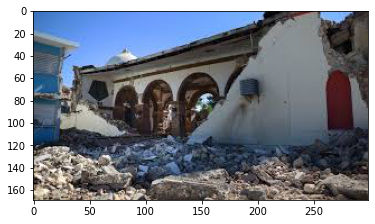

No damage: 0.07202345
Some damage: 0.9279639
Classification:  Severe damage


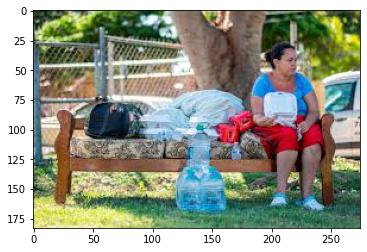

No damage: 0.99937624
Some damage: 0.0006216613
Classification:  No damage


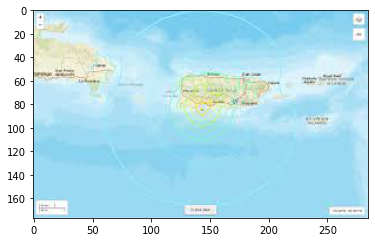

No damage: 0.99939585
Some damage: 0.0006024814
Classification:  No damage


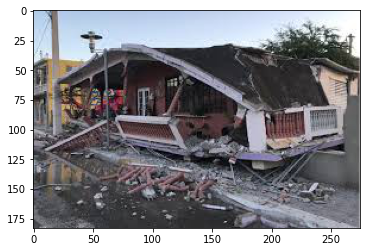

No damage: 0.014417935
Some damage: 0.9855742
Classification:  Severe damage


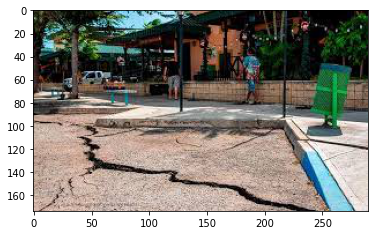

No damage: 0.9993414
Some damage: 0.00065609853
Classification:  No damage


In [ ]:
path = os.path.expanduser('puerto_rico_test/')

import glob
images = glob.glob(path + '/*.jpg')

for img in images:
  img_show(img)
  img_prediction(img)